In [ ]:
import mrcnn
import mrcnn.config
import mrcnn.model
import mrcnn.visualize
import cv2
import os

# load the class label names from disk, one label per line
# CLASS_NAMES = open("coco_labels.txt").read().strip().split("\n")

CLASS_NAMES = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']

class SimpleConfig(mrcnn.config.Config):
    # Give the configuration a recognizable name
    NAME = "coco_inference"
    
    # set the number of GPUs to use along with the number of images per GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

	# Number of classes = number of classes + 1 (+1 for the background). The background class is named BG
    NUM_CLASSES = len(CLASS_NAMES)

# Initialize the Mask R-CNN model for inference and then load the weights.
# This step builds the Keras model architecture.
model = mrcnn.model.MaskRCNN(mode="inference", 
                             config=SimpleConfig(),
                             model_dir=os.getcwd())

# Load the weights into the model.
# Download the mask_rcnn_coco.h5 file from this link: https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
model.load_weights(filepath="mask_rcnn_coco.h5", 
                   by_name=True)

# load the input image, convert it from BGR to RGB channel
image = cv2.imread("sample_image.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Perform a forward pass of the network to obtain the results
r = model.detect([image], verbose=0)

# Get the results for the first image.
r = r[0]

# Visualize the detected objects.
mrcnn.visualize.display_instances(image=image, 
                                  boxes=r['rois'], 
                                  masks=r['masks'], 
                                  class_ids=r['class_ids'], 
                                  class_names=CLASS_NAMES, 
                                  scores=r['scores'])

In [ ]:
import tensorflow as tf
gpu_available = tf.test.is_gpu_available()
is_cuda_gpu_available = tf.test.is_gpu_available(cuda_only=True)
is_cuda_gpu_min_3 = tf.test.is_gpu_available(True, (3,0))

In [ ]:
is_cuda_gpu_available


In [ ]:
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import random
import os
import cv2
#from tensorflow.keras.preprocessing.image import ImageDataGenerator

## For visualizing results
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


def sem_seg_data_gen(ann_path, img_dir, batch_size, input_image_size, mask_type):
    '''
    Data generator for semantic segmentation
    '''
    
    def filterDataset(ann_path, classes, ):    
        # initialize COCO api for instance annotations
        annFile = ann_path
        coco = COCO(annFile)
        
        images = []
        if classes!=None:
            # iterate for each individual class in the list
            for className in classes:
                # get all images containing given categories
                catIds = coco.getCatIds(catNms=className)
                imgIds = coco.getImgIds(catIds=catIds)
                images += coco.loadImgs(imgIds)
        
        else:
            imgIds = coco.getImgIds()
            images = coco.loadImgs(imgIds)
        
        # Now, filter out the repeated images
        unique_images = []
        for i in range(len(images)):
            if images[i] not in unique_images:
                unique_images.append(images[i])
                
        random.shuffle(unique_images)
        dataset_size = len(unique_images)
        
        return unique_images, dataset_size, coco
    
    coco = COCO(ann_path)
    
    catIDs = coco.getCatIds()
    cats = coco.loadCats(catIDs)

    nms=[cat['name'] for cat in cats]
    print(len(nms),'COCO categories: \n{}\n'.format(', '.join(nms)))

    nms = set([cat['supercategory'] for cat in cats])
    print(len(nms),'COCO supercategories: \n{}'.format(' '.join(nms)))
    
    '''classes = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 
               'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack',
               'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
               'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
               'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant',
               'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
               'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']'''
               
    classes = ['cat1']
    
    def getClassName(classID, cats):
        for i in range(len(cats)):
            if cats[i]['id']==classID:
                return cats[i]['name']
        return None

    def getImage(imageObj, img_folder, input_image_size):
        # Read and normalize an image
        train_img = io.imread(img_folder + '/' + imageObj['file_name'])/255.0
        # Resize
        train_img = cv2.resize(train_img, input_image_size)
        if (len(train_img.shape)==3 and train_img.shape[2]==3): # If it is a RGB 3 channel image
            return train_img
        else: # To handle a black and white image, increase dimensions to 3
            stacked_img = np.stack((train_img,)*3, axis=-1)
            return stacked_img
    
    def getNormalMask(imageObj, classes, coco, catIds, input_image_size):
        annIds = coco.getAnnIds(imageObj['id'], catIds=catIds, iscrowd=None)
        anns = coco.loadAnns(annIds)
        cats = coco.loadCats(catIds)
        train_mask = np.zeros(input_image_size)
        for a in range(len(anns)):
            className = getClassName(anns[a]['category_id'], cats)
            #print(className)
            pixel_value = classes.index(className)+1
            new_mask = cv2.resize(coco.annToMask(anns[a])*pixel_value, input_image_size)
            train_mask = np.maximum(new_mask, train_mask)

        # Add extra dimension for parity with train_img size [X * X * 3]
        train_mask = train_mask.reshape(input_image_size[0], input_image_size[1], 1)
        return train_mask  
    
    def getBinaryMask(imageObj, coco, catIds, input_image_size):
        annIds = coco.getAnnIds(imageObj['id'], catIds=catIds, iscrowd=None)
        anns = coco.loadAnns(annIds)
        train_mask = np.zeros(input_image_size)
        for a in range(len(anns)):
            new_mask = cv2.resize(coco.annToMask(anns[a]), input_image_size)
            
            #Threshold because resizing may cause extraneous values
            new_mask[new_mask >= 0.5] = 1
            new_mask[new_mask < 0.5] = 0

            train_mask = np.maximum(new_mask, train_mask)

        # Add extra dimension for parity with train_img size [X * X * 3]
        train_mask = train_mask.reshape(input_image_size[0], input_image_size[1], 1)
        return train_mask


    def dataGeneratorCoco(images, classes, coco, folder, 
                        input_image_size=(224,224), batch_size=4, mask_type='binary'):
        
        img_folder = '{}'.format(folder)
        dataset_size = len(images)
        catIds = coco.getCatIds(catNms=classes)
        
        c = 0
        while(True):
            img = np.zeros((batch_size, input_image_size[0], input_image_size[1], 3)).astype('float')
            mask = np.zeros((batch_size, input_image_size[0], input_image_size[1], 1)).astype('float')

            for i in range(c, c+batch_size): #initially from 0 to batch_size, when c = 0
                imageObj = images[i]
                
                ### Retrieve Image ###
                #print(imageObj)
                train_img = getImage(imageObj, img_folder, input_image_size)
                
                ### Create Mask ###
                if mask_type=="binary":
                    train_mask = getBinaryMask(imageObj, coco, catIds, input_image_size)
                
                elif mask_type=="normal":
                    train_mask = getNormalMask(imageObj, classes, coco, catIds, input_image_size)                
                
                # Add to respective batch sized arrays
                img[i-c] = train_img
                mask[i-c] = train_mask
                
            c+=batch_size
            if(c + batch_size >= dataset_size):
                c=0
                random.shuffle(images)
            
            assert not np.any(np.isnan(img))
            assert not np.any(np.isnan(mask))
            
            yield img, mask/255
            
        
    images, dataset_size, coco = filterDataset(ann_path, classes,)
    
    data_gen = dataGeneratorCoco(images, classes, coco, img_dir,
                            input_image_size, batch_size, mask_type)
    
    return data_gen, dataset_size

In [8]:
train_sem_seg_gen, train_dataset_size = sem_seg_data_gen(ann_path=r'D:\Nirwan\MRCNN_TF2\Mask-RCNN-TF2\ishape_dataset\wire\train\coco_format\instances_train2017.json',
                                             img_dir=r'D:\Nirwan\MRCNN_TF2\Mask-RCNN-TF2\ishape_dataset\wire\train\coco_format\train2017',
                                             batch_size=4, input_image_size=(128,128), mask_type='binary')
val_sem_seg_gen, val_dataset_size = sem_seg_data_gen(ann_path=r'D:\Nirwan\MRCNN_TF2\Mask-RCNN-TF2\ishape_dataset\wire\val\coco_format\instances_train2017.json',
                                             img_dir=r'D:\Nirwan\MRCNN_TF2\Mask-RCNN-TF2\ishape_dataset\wire\val\coco_format\train2017',
                                             batch_size=4, input_image_size=(128,128), mask_type='binary')
    

loading annotations into memory...
Done (t=0.70s)
creating index...
index created!
1 COCO categories: 
cat1

1 COCO supercategories: 
supercat1
loading annotations into memory...
Done (t=0.31s)
creating index...
index created!
loading annotations into memory...
Done (t=0.08s)
creating index...
index created!
1 COCO categories: 
cat1

1 COCO supercategories: 
supercat1
loading annotations into memory...
Done (t=0.07s)
creating index...
index created!


In [14]:
def visualizeGenerator(gen):
    img, mask = next(gen)
    
    fig = plt.figure(figsize=(20, 10))
    outerGrid = gridspec.GridSpec(1, 2, wspace=0.1, hspace=0.1)
    
    for i in range(2):
        innerGrid = gridspec.GridSpecFromSubplotSpec(2, 2,
                        subplot_spec=outerGrid[i], wspace=0.05, hspace=0.05)

        for j in range(4):
            ax = plt.Subplot(fig, innerGrid[j])
            if(i==1):
                ax.imshow(img[j])
            else:
                ax.imshow(mask[j][:,:,0])
                
            ax.axis('off')
            fig.add_subplot(ax)        
    plt.show()

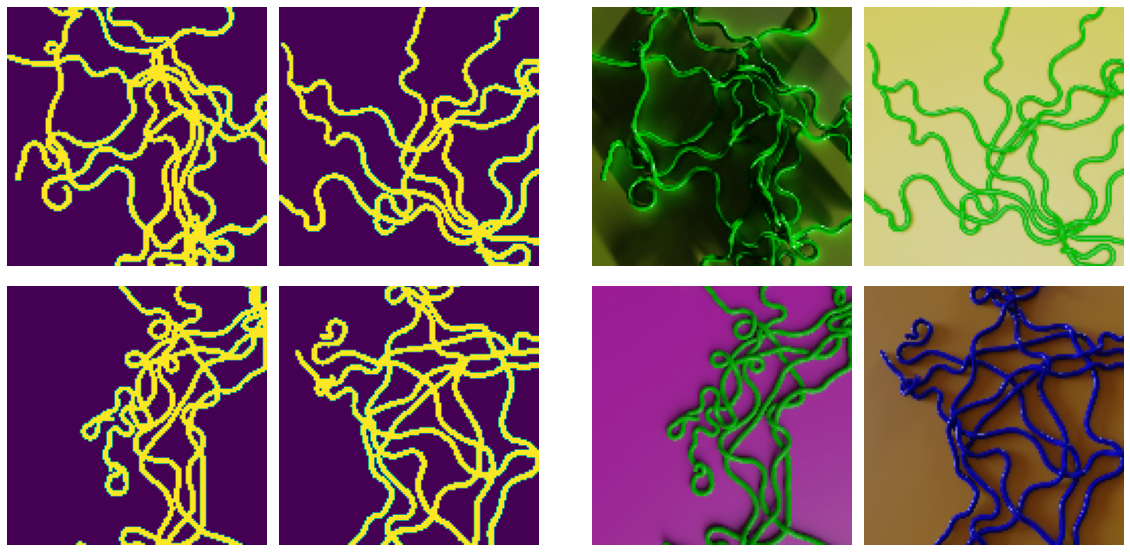

In [15]:
visualizeGenerator(val_sem_seg_gen)

In [9]:
#import tensorflow_advanced_segmentation_models as tasm
import tensorflow as tf
import keras

In [10]:
import segmentation_models as sm

In [11]:


print("Training semantic model...")
print("================================================================")
n_epochs = 15
batch_size = 4
        
steps_per_epoch = train_dataset_size // batch_size
validation_steps = val_dataset_size // batch_size
    
optim = keras.optimizers.Adam(0.0001)
dice_loss = sm.losses.DiceLoss(class_weights=np.ones(1)) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]


Training semantic model...


In [12]:
seg_model = sm.Unet('efficientnetb7', classes=1, activation='sigmoid')

In [16]:
seg_model.compile(optim, total_loss, metrics='accuracy')
history = seg_model.fit(x=train_sem_seg_gen, validation_data=val_sem_seg_gen, epochs=10, steps_per_epoch=steps_per_epoch,
                        validation_steps=validation_steps, verbose=True, #callbacks=callback
                        )

Epoch 1/10
500/500 [==============================] - 208s 345ms/step - loss: 0.9932 - accuracy: 0.7711 - val_loss: 0.9927 - val_accuracy: 0.7770
Epoch 2/10
 53/500 [==>...........................] - ETA: 1:58 - loss: 0.9927 - accuracy: 0.7769

KeyboardInterrupt: 